### 地表覆盖/土地利用（LCLU）栅格数据分析（昆明）  
DEM数据来源：https://livingatlas.arcgis.com/landcoverexplorer


In [ ]:
import geopandas as gpd
import rasterio as rio
import matplotlib.pyplot as plt


#### 1. 矢量数据准备   
1.1 包含5个行政区；  
1.2 计算面积列；  


In [9]:
path_kunming = 'data/data-section-6/kunming_districts.gpkg'
path_kunming_save = 'data/data-section-6/kunming_5districts_utm48.gpkg'


In [4]:
kunming_gpd = gpd.read_file(path_kunming)
print(kunming_gpd.total_bounds)
kunming_gpd.head()
### 筛选主城区
kunming_gpd = kunming_gpd[kunming_gpd['dt_name'].isin(['五华区', '官渡区', '盘龙区', '呈贡区', '西山区'])]
kunming_gpd.head()



[102.171088  24.3852   103.67025   26.541846]


,dt_adcode,dt_name,ct_adcode,ct_name,pr_adcode,pr_name,cn_adcode,cn_name,geometry
0,530102,五华区,530100,昆明市,530000,云南省,100000,中华人民共和国,"MULTIPOLYGON (((102.71331 25.13652, 102.71547 ..."
1,530103,盘龙区,530100,昆明市,530000,云南省,100000,中华人民共和国,"MULTIPOLYGON (((102.71668 25.04473, 102.71663 ..."
2,530111,官渡区,530100,昆明市,530000,云南省,100000,中华人民共和国,"MULTIPOLYGON (((102.71717 25.03341, 102.71792 ..."
3,530112,西山区,530100,昆明市,530000,云南省,100000,中华人民共和国,"MULTIPOLYGON (((102.50726 24.86019, 102.50689 ..."
5,530114,呈贡区,530100,昆明市,530000,云南省,100000,中华人民共和国,"MULTIPOLYGON (((102.85321 24.69792, 102.85168 ..."


In [5]:
#### 计算面积
kunming_gpd_utm48 = kunming_gpd.to_crs(epsg=32648)
areas = kunming_gpd_utm48.area/1000000


In [7]:
kunming_gpd_utm48['area(km2)'] = areas
kunming_gpd_utm48


,dt_adcode,dt_name,ct_adcode,ct_name,pr_adcode,pr_name,cn_adcode,cn_name,geometry,area(km2)
0,530102,五华区,530100,昆明市,530000,云南省,100000,中华人民共和国,"MULTIPOLYGON (((269466.597 2782018.804, 269686...",388.681330
1,530103,盘龙区,530100,昆明市,530000,云南省,100000,中华人民共和国,"MULTIPOLYGON (((269635.126 2771844.039, 269631...",864.295297
2,530111,官渡区,530100,昆明市,530000,云南省,100000,中华人民共和国,"MULTIPOLYGON (((269663.017 2770589.114, 269738...",638.333617
3,530112,西山区,530100,昆明市,530000,云南省,100000,中华人民共和国,"MULTIPOLYGON (((248122.204 2751771.711, 248084...",887.075812
5,530114,呈贡区,530100,昆明市,530000,云南省,100000,中华人民共和国,"MULTIPOLYGON (((282807.685 2733200.548, 282654...",499.363964


In [10]:
kunming_gpd_utm48.to_file(path_kunming_save, driver='GPKG')



#### 2. 栅格数据准备

In [21]:
path_lclu_2017 = 'data/data-section-6/48R_20170101-20180101.tif'
path_lclu_2017_clip = 'data/data-section-6/48R_20170101-20180101_clip.tif'
path_lclu_2024 = 'data/data-section-6/48R_20240101-20241231.tif'
path_lclu_2024_clip = 'data/data-section-6/48R_20240101-20241231_clip.tif'


In [22]:
lclu_2017_src = rio.open(path_lclu_2017)
lclu_2017_src.meta


{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 61044,
 'height': 89013,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 48N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(10.0, 0.0, 194780.0,
        0.0, -10.0, 3544360.0)}

In [23]:
lclu_2017_src.read(1).shape


(89013, 61044)

In [24]:
# plt.imshow(lclu_2017_src.read(1), cmap='tab20', vmin=0, vmax=20)   ## 数据量太大，无法显示


In [25]:
#### 矢量裁剪
from rasterio.mask import mask
# 使用mask函数裁剪栅格
lclu_2017_clip_data, lclu_2017_clip_transform = mask(    
    dataset=lclu_2017_src,
    shapes=list(kunming_gpd_utm48.geometry),  # 使用GeoDataFrame的geometry列
    crop=True,              # 将栅格裁剪到矢量边界
    all_touched=False,      # 仅裁剪中心点在矢量内的像元
    nodata=lclu_2017_src.nodata       # 无效值设为原始栅格的nodata
)


In [32]:
lclu_2017_src.close()


In [26]:
lclu_2017_clip_data.shape


(1, 8423, 7026)

In [27]:
# 更新输出文件的元数据（尺寸、坐标系等）
clip_meta = lclu_2017_src.meta.copy()
clip_meta.update({
    "height": lclu_2017_clip_data.shape[1],  # 行数（高度）
    "width": lclu_2017_clip_data.shape[2],   # 列数（宽度）
    "transform": lclu_2017_clip_transform    # 新的地理变换矩阵
})



In [28]:
clip_meta


{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 7026,
 'height': 8423,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 48N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(10.0, 0.0, 233000.0,
        0.0, -10.0, 2817430.0)}

In [30]:
# 保存裁剪后的栅格
with rio.open(fp = path_lclu_2017_clip, 
            mode = "w", 
            driver = clip_meta['driver'],
            height = clip_meta['height'],
            width = clip_meta['width'],
            count = clip_meta['count'],
            dtype = clip_meta['dtype'],
            crs = clip_meta['crs'],
            transform = lclu_2017_clip_transform) as dst:
    dst.write(lclu_2017_clip_data)


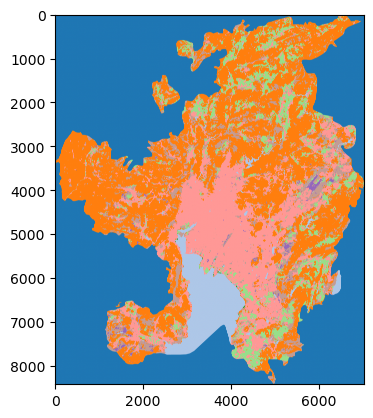

In [31]:
plt.imshow(lclu_2017_clip_data[0], cmap='tab20', vmin=0, vmax=20)
